In [1]:
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from scipy import spatial
from scipy.stats import kendalltau
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import mnist, fashion_mnist
from torchvision.models.resnet import resnet18
import torch
import pandas as pd

c:\Users\kara\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data/Setting

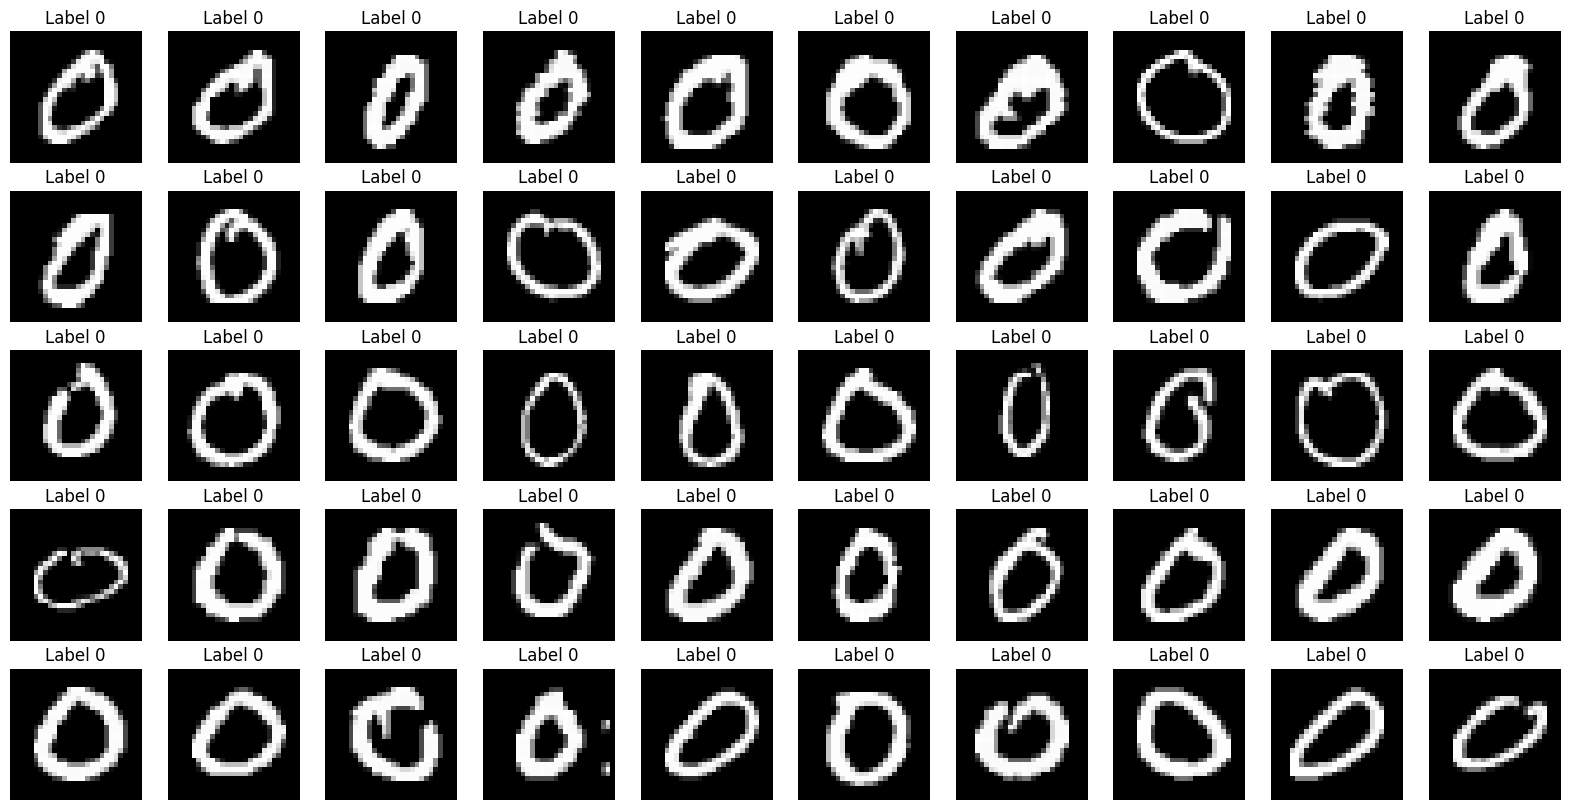

In [2]:
which_dataset = 'mnist' # or fashion_mnist
dtype = 'img' # or feat

if which_dataset == 'mnist':
    (train_images_all, train_labels_all), (test_images_all, test_labels_all) = mnist.load_data()
elif which_dataset == 'fashion_mnist':
    (train_images_all, train_labels_all), (test_images_all, test_labels_all) = fashion_mnist.load_data()
else:
    raise NotImplementedError

# Pick samples
rows,cols = 5,10
n = rows*cols
# temp = [i for i in range(len(train_labels_all)) if train_labels_all[i]==5]   # only use images with specific label

#temp = range(len(train_labels_all))    # use any image
# index_subset = random.sample(temp,n)
T_train_images = []
T_train_labels = []
for label in range(10):
    counter = 0
    for i in range(len(train_images_all)):
        if train_labels_all[i] == label:
            T_train_images.append(train_images_all[i])
            T_train_labels.append(train_labels_all[i])
            counter += 1
        if counter == 50:
            break

# shuffle
_index = list(range(len(T_train_images)))
# random.shuffle(_index)
train_images = []
train_labels = []
for i in _index:
    train_images.append(T_train_images[i])
    train_labels.append(T_train_labels[i])

train_images = np.array(train_images)
# temp2 = sorted(train_labels)
train_labels = np.array(train_labels)
# train_labels = np.array([temp2.index(i)+1 for i in train_labels])

# Random ranking
fig, axs = plt.subplots(rows, cols, figsize=(20, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(train_images[i], cmap="gray")
    ax.set_axis_off()
    ax.set_title("Label {}".format(train_labels[i]))

plt.show()

# print("Ranked:")
# # Real ranking
# sorted_indices = np.argsort(train_labels)
# sorted_labels = train_labels[sorted_indices]
# sorted_images = train_images[sorted_indices]

# fig, axs = plt.subplots(rows, cols, figsize=(20, 10))
# for i, ax in enumerate(axs.flat):
#     ax.imshow(sorted_images[i], cmap="gray")
#     ax.set_axis_off()
#     ax.set_title("Label {}".format(sorted_labels[i]))

# plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils
from torch.optim.lr_scheduler import StepLR

class DataSet(torch.utils.data.Dataset):
    def __init__(self, data, label):
        self.data = torch.from_numpy(data.astype('float32'))/255
        self.label = torch.from_numpy(label.astype('int'))
    
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index):
        return self.data[index][None], self.label[index]
        
        

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, 3, 1), nn.ReLU(), nn.Dropout(0.25))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 3, 1), nn.ReLU(), nn.Dropout(0.25))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        feat = F.adaptive_max_pool2d(x, (1, 1))[:, :, 0, 0]
        x = self.fc(feat)
        output = F.log_softmax(x, dim=1)
        return feat, output


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # print(data.shape)
        optimizer.zero_grad()
        _, output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            _, output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


torch.manual_seed(0)
device = torch.device("cpu")

dataset1 = DataSet(train_images_all, train_labels_all)
dataset2 = DataSet(test_images_all, test_labels_all)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=1024)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1024)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# for epoch in range(1, 50 + 1):
#     train(model, device, train_loader, optimizer, epoch)
#     test(model, device, test_loader)
#     torch.save(model.state_dict(), './ckpt.pth')

In [4]:
# # use resnet 18 to extract feature of raw images
if dtype == 'feat':
    train_images = torch.from_numpy(train_images.astype('float32'))/255-0.5
    # train_images = torch.stack([train_images for _ in range(3)], dim=1)
    train_images = train_images[:, None]
    # train_images = torch.nn.functional.interpolate(train_images, size=(128, 128), mode='bilinear')
    # msg = model.load_state_dict(torch.load('./ckpt.pth', map_location='cpu'))
    if which_dataset == 'fashion_mnist':
        msg = model.load_state_dict(torch.load('./fashion_ckpt.pth', map_location='cpu'))
    elif which_dataset == 'mnist':
        msg = model.load_state_dict(torch.load('./mnist_ckpt.pth', map_location='cpu'))
    else:
        raise NotImplementedError

    # model = resnet18(pretrained=True)
    # model.fc = nn.Sequential()
    # print(msg)
    model = model.cpu()
    # print(resnet18)
    with torch.no_grad():
        train_images, _ = model(train_images)
    # 
    train_images = train_images[:, :, None].numpy()
print(train_images.shape)

SyntaxError: invalid syntax (2664995658.py, line 8)

In [ ]:
train_images[0].shape

(64, 1)

# Diffusion Map

# MDS

(500, 2)


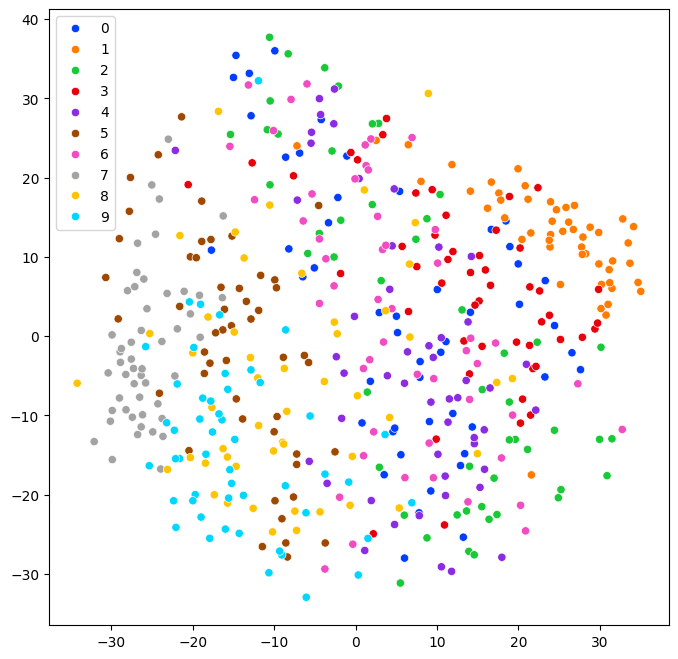

In [ ]:
# load the data
images = train_images.copy()
labels = train_labels.copy()

# Compute the MDS embedding on the top two eigenvectors
mds = MDS(n_components=2, random_state=0)
X = images.reshape((images.shape[0], -1))
images_tsne = mds.fit_transform(X)
print(images_tsne.shape)
plt.figure(figsize=(8, 8)) 
# for index in range(len(labels)):
sns.scatterplot(x=images_tsne[:, 0], y= images_tsne[:, 1], hue=labels, legend='full', palette='bright') 

plt.show()

# ISOMAP

(500, 2)


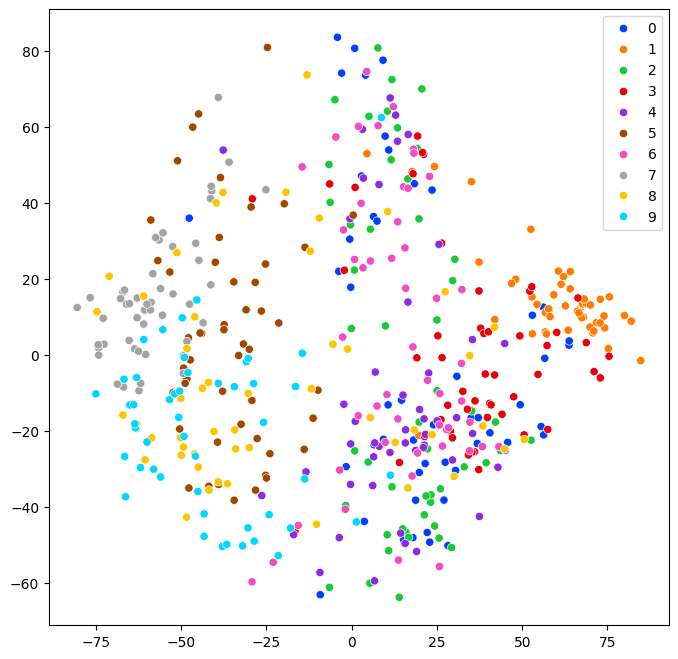

In [ ]:
# load the data
images = train_images.copy()
labels = train_labels.copy()
# create an Isomap object with n_components=1 and n_neighbors=5
isomap = Isomap(n_components=2, n_neighbors=5)
# fit the Isomap object to the data
X = images.reshape((images.shape[0], -1))
isomap.fit(X)
# get the embedded data
images_tsne = isomap.transform(X)
# plot
print(images_tsne.shape)

# data = np.vstack([images_tsne, labels.reshape(50, 1)])
# images_tsne = pd.DataFrame(data, columns=['Dim1', 'Dim2', 'class'])
plt.figure(figsize=(8, 8)) 
# for index in range(len(labels)):
sns.scatterplot(x=images_tsne[:, 0], y= images_tsne[:, 1], hue=labels, legend='full', palette='bright') 

plt.show()

# LLE

(500, 2)


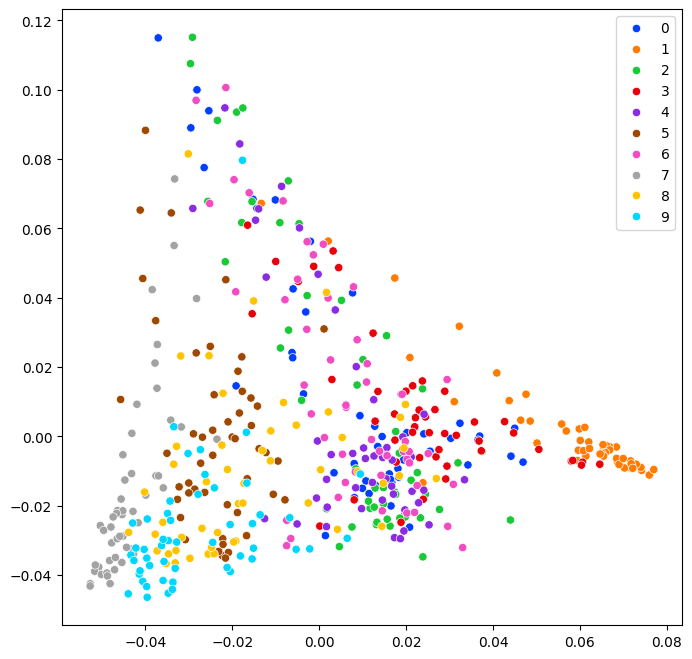

In [ ]:
# load the data
images = train_images.copy()
labels = train_labels.copy()
# create a LocallyLinearEmbedding object with n_components=1, n_neighbors=5, and method='standard'
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=15, method="standard")
# fit the LLE object to the data
X = images.reshape((images.shape[0], -1))
lle.fit(X)
# get the embedded data
images_tsne = lle.transform(X)
# plot
images_tsne = images_tsne/ np.linalg.norm(images_tsne)
print(images_tsne.shape)

# data = np.vstack([images_tsne, labels.reshape(50, 1)])
# images_tsne = pd.DataFrame(data, columns=['Dim1', 'Dim2', 'class'])
plt.figure(figsize=(8, 8)) 
# for index in range(len(labels)):
sns.scatterplot(x=images_tsne[:, 0], y= images_tsne[:, 1], hue=labels, legend='full', palette='bright') 

plt.show()

# TSNE

(500, 2)


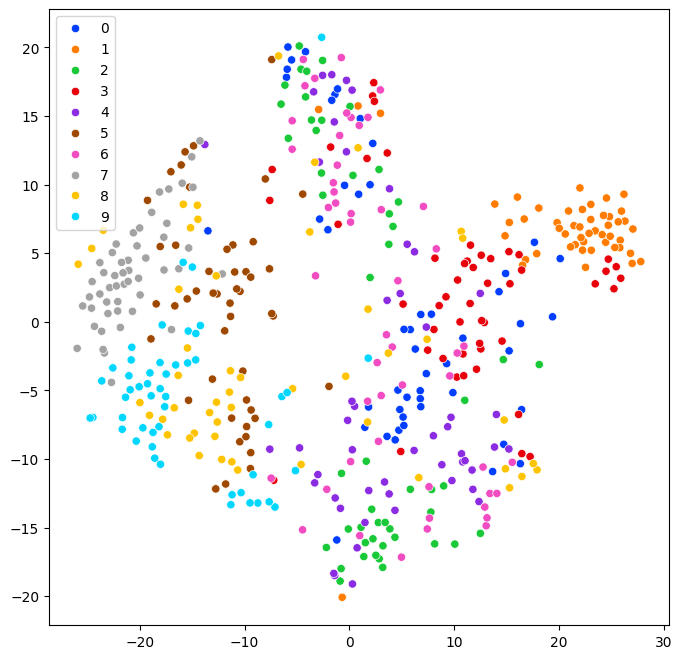

In [ ]:
# load the data
images = train_images
labels = train_labels
# Use t-SNE to reduce the dimensionality of the face data to 2D
tsne = TSNE(n_components=2)
X = images.reshape((images.shape[0], -1))
images_tsne = tsne.fit_transform(X)
print(images_tsne.shape)
plt.figure(figsize=(8, 8)) 
# for index in range(len(labels)):
sns.scatterplot(x=images_tsne[:, 0], y= images_tsne[:, 1], hue=labels, legend='full', palette='bright') 

plt.show()

In [ ]:
images.shape

(500, 64, 1)

# UMAP

(500, 2)


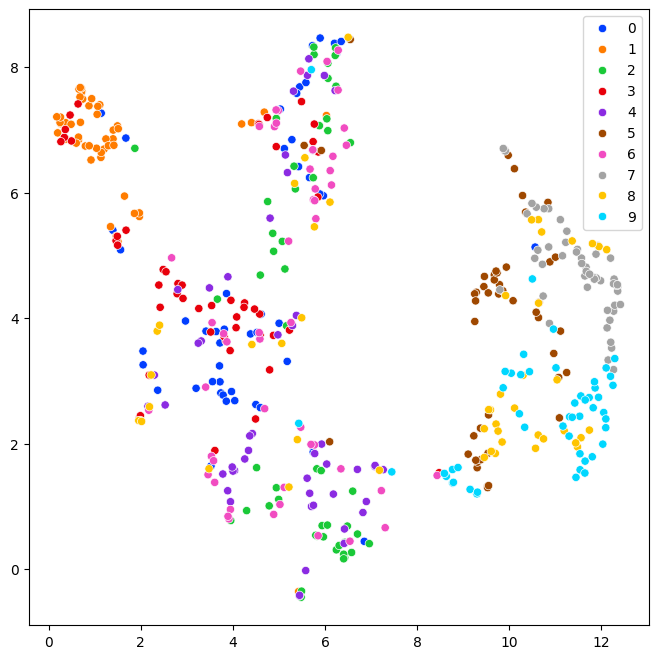

In [ ]:
# load the data
images = train_images.copy()
labels = train_labels.copy()
# Use UMAP to reduce the dimensionality of the face data to 2D
model = umap.UMAP(n_components=2, n_neighbors=5)
# Fit model to data
X = images.transpose(2, 0, 1).reshape((images.shape[0], -1))
images_tsne = model.fit_transform(X)
print(images_tsne.shape)

# data = np.vstack([images_tsne, labels.reshape(50, 1)])
# images_tsne = pd.DataFrame(data, columns=['Dim1', 'Dim2', 'class'])
plt.figure(figsize=(8, 8)) 
# for index in range(len(labels)):
sns.scatterplot(x=images_tsne[:, 0], y= images_tsne[:, 1], hue=labels, legend='full', palette='bright') 

plt.show()